In [17]:
import numpy as np
A = np.array([[1, 2, 3],
              [2, 5, 2],
              [6, -3, 1]])

b = np.array([[6],
              [4],
              [2]])

### **Gussian Elimination**

In [18]:


class GaussianEliminator:
    def __init__(self, A, b):
        self.A = A.astype(float).copy() # Matrix A
        self.b = b.astype(float).copy() # vector b
        self.n = self.A.shape[0]
        self.steps = []

    def eliminate(self):
        """
        Perform Gaussian elimination and convert [A|b] to Row Echelon Form (REF).
        """
        for i in range(self.n):
            
            # Handle zero pivot
            if np.isclose(self.A[i, i], 0):
                swapped = False
                for j in range(i + 1, self.n):
                    if not np.isclose(self.A[j, i], 0):
                        self._swap_rows(i, j)
                        self.steps.append(f"Swapped row {i} with row {j} (pivot was zero).")
                        swapped = True
                        break
                if not swapped:
                    self.steps.append(f"Column {i} pivot is zero and unswappable. Skipping.")
                    continue

            pivot = self.A[i, i] 

            # Elimination
            for j in range(i + 1, self.n):
                multiplier = self.A[j, i] / pivot # multiplier
                self.A[j] -= multiplier * self.A[i] # eliminate an entry in A
                self.b[j] -= multiplier * self.b[i] # eliminate b
                self.steps.append(f"R{j+1} → R{j+1} - ({multiplier:.2f}) × R{i+1}") # steps

    def _swap_rows(self, i, j):
        """Used if there's a zero in pivot position"""
        self.A[[i, j]] = self.A[[j, i]]
        self.b[[i, j]] = self.b[[j, i]]

    def get_augmented_matrix(self):
        """Transform A and b to augmented matrix"""
        return np.column_stack((self.A, self.b))

    def print_steps(self):
        print("Steps:")
        for step in self.steps:
            print(step)

    def print_result(self):
        print("Row Echelon Form [A|b]:")
        print(self.get_augmented_matrix())

eliminator = GaussianEliminator(A, b)
eliminator.eliminate()
eliminator.print_steps()
eliminator.print_result()

Steps:
R2 → R2 - (2.00) × R1
R3 → R3 - (6.00) × R1
R3 → R3 - (-15.00) × R2
Row Echelon Form [A|b]:
[[   1.    2.    3.    6.]
 [   0.    1.   -4.   -8.]
 [   0.    0.  -77. -154.]]


### **Solution Type Detection**

In [19]:
import numpy as np

def detect_solution_type(A, b):
    """
    Detects the type of solution for the linear system Ax = b
    using the rank of A and the augmented matrix [A|b].
    """
    A = A.astype(float) # Matrix A
    b = b.reshape(-1, 1).astype(float) # vector b

    augmented = np.column_stack((A, b)) # make Ab augmented
    rank_A = np.linalg.matrix_rank(A) # computes the rank of the matrix A
    rank_aug = np.linalg.matrix_rank(augmented) # computes the rank of the augmented matrix [A|b]
    n = A.shape[1]  # number of variables

    if rank_A == rank_aug == n:
        return "Unique solution"
    elif rank_A == rank_aug < n:
        return "Infinite solutions"
    elif rank_A < rank_aug:
        return "No solution"
    else:
        return "Indeterminate case"

result = detect_solution_type(A, b)
print(result)

Unique solution


### **Back Subtitution**

In [21]:
def back_substitution_with_steps(U, b):
    """
    Perform back substitution on upper triangular matrix Ux = b.
    """
    n = U.shape[0] 
    x = np.zeros((n, 1))
    steps = []

    for i in reversed(range(n)): # Start from the last row and move upward (back substitution)

        # This computes the sum of the known terms in the equation:
        # U[i, i+1:] → the coefficients to the right of the pivot in row i
        # x[i+1:] → the values already solved for (x_{i+1}, x_{i+2}, ...)
        # So this is: a_{i,i+1} * x_{i+1} + a_{i,i+2} * x_{i+2} + ...
        sum_ = np.dot(U[i, i+1:], x[i+1:])
        
        # Solve for the unknown x[i] using:
        # x[i] = (right-hand-side - sum of known terms) / pivot
        x[i] = (b[i] - sum_) / U[i, i]  
       
        # Build a readable string like "4.00·x3 + 2.00·x4" for logging steps
        terms = " + ".join([f"{U[i, j]:.2f}·x{j+1}" for j in range(i+1, n)])  
        
        # Construct the full algebraic expression for this step
        eq = f"x{i+1} = ({b[i][0]:.2f} - ({terms})) / {U[i, i]:.2f}"  
        
        # If there are no terms (i.e., last row), simplify the expression
        eq = eq if terms else f"x{i+1} = {b[i][0]:.2f} / {U[i, i]:.2f}"  
        
        # Append the full line to the log: what we did, what x[i] equals
        steps.append(eq + f" = {x[i][0]:.2f}")  


    print("Back Substitution Steps:")
    for s in steps:
        print(s)

    return x


def solve_linear_system_verbose(A, b):
    """Solves Ax = b by Gaussian elimination followed by back substitution."""

    eliminator = GaussianEliminator(A, b)
    eliminator.eliminate()

    U = eliminator.A
    c = eliminator.b
    return back_substitution_with_steps(U, c)


eliminator.print_result()
x = solve_linear_system_verbose(A, b)
print("Solution:\n", x)

Row Echelon Form [A|b]:
[[   1.    2.    3.    6.]
 [   0.    1.   -4.   -8.]
 [   0.    0.  -77. -154.]]
Back Substitution Steps:
x3 = -154.00 / -77.00 = 2.00
x2 = (-8.00 - (-4.00·x3)) / 1.00 = 0.00
x1 = (6.00 - (2.00·x2 + 3.00·x3)) / 1.00 = 0.00
Solution:
 [[0.]
 [0.]
 [2.]]


### **Visualization**

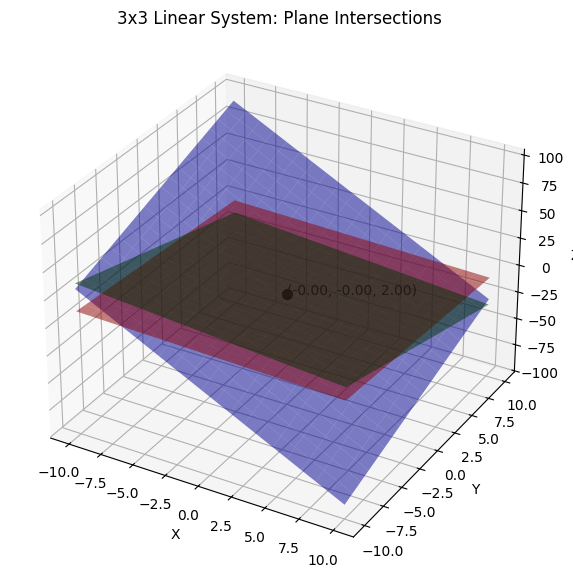

In [23]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def visualize_elimination(A, b):
    """
    Visualize a linear system Ax = b as:
    - Lines for 2x2 systems
    - Planes for 3x3 systems
    """
    A = np.array(A, dtype=float)
    b = np.array(b, dtype=float).flatten()
    n = A.shape[0]

    if n == 2:
        # Plot 2D lines
        x_vals = np.linspace(-10, 10, 200)
        plt.figure(figsize=(7, 5))
        for i in range(2):
            a1, a2 = A[i]
            if np.isclose(a2, 0):
                x0 = b[i] / a1
                plt.axvline(x=x0, label=f"Eq {i+1}", linestyle='--')
            else:
                y_vals = (b[i] - a1 * x_vals) / a2
                plt.plot(x_vals, y_vals, label=f"Eq {i+1}")
        plt.xlabel('x')
        plt.ylabel('y')
        plt.axhline(0, color='black', linewidth=0.5)
        plt.axvline(0, color='black', linewidth=0.5)
        plt.title("2x2 Linear System: Line Intersections")
        plt.grid(True)
        plt.legend()
        plt.show()

    elif n == 3:
        # Plot 3D planes
        fig = plt.figure(figsize=(10, 7))
        ax = fig.add_subplot(111, projection='3d')

        x_vals = np.linspace(-10, 10, 20)
        y_vals = np.linspace(-10, 10, 20)
        X, Y = np.meshgrid(x_vals, y_vals)

        colors = ['red', 'green', 'blue']
        for i in range(3):
            a, b_, c = A[i]
            if not np.isclose(c, 0):
                Z = (b[i] - a * X - b_ * Y) / c
                ax.plot_surface(X, Y, Z, alpha=0.5, color=colors[i])
            else:
                ax.text(0, 0, 0, f"Plane {i+1} not plottable (z-term missing)")

        # Show intersection point if it exists
        try:
            sol = np.linalg.solve(A, b)
            ax.scatter(*sol, color='black', s=50)
            ax.text(*sol, f"({sol[0]:.2f}, {sol[1]:.2f}, {sol[2]:.2f})", color='black')
        except np.linalg.LinAlgError:
            pass  # No solution or infinite solutions

        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        ax.set_title("3x3 Linear System: Plane Intersections")
        plt.show()

    else:
        print("Only 2x2 or 3x3 systems are supported.")

visualize_elimination(A, b)